In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, multilabel_confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from utils import get_dfs
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

#Getting the dataset
data_df, data_ordinal_df, holdout_df = get_dfs()

/Users/emilvinther/ITU/3_semester/data mining/DataMining/utils.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['track_album_release_date'] = pd.to_datetime(
/Users/emilvinther/ITU/3_semester/data mining/DataMining/utils.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['track_album_release_date'].dt.year


Mean Squared Error: 0.012
R2: 42.13%
Mean Absolute Error: 0.087


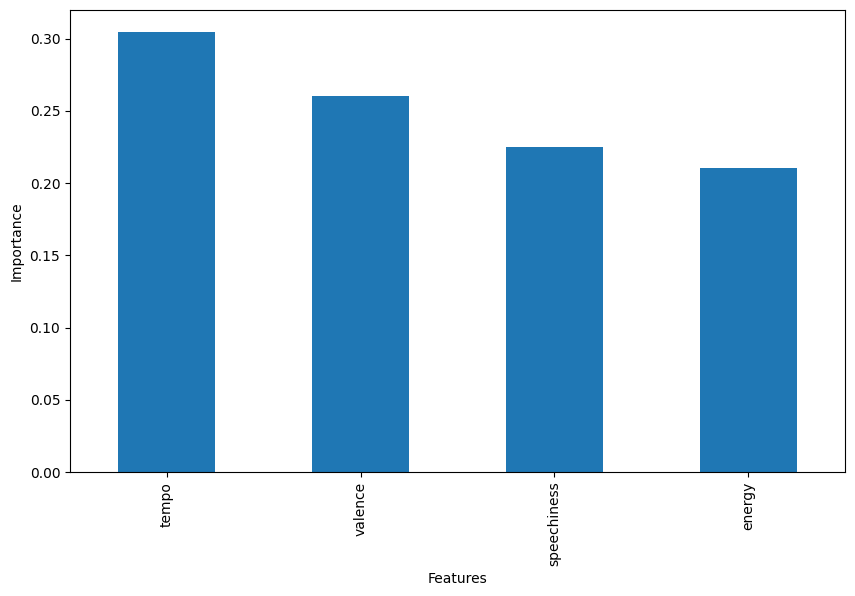

In [2]:
########################################################################################
########################################################################################

########################    Random Forest Generator   #####################################

########################################################################################
########################################################################################

#setting up training columns
rhythm_related_columns = ['tempo','energy', 'valence','speechiness']

#setting rhytm related columns as input features
X = data_ordinal_df[rhythm_related_columns]
#making danceability our target feature
y = data_df['danceability']

#setting the training size på 70% and test 30%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

#using min-max scaling as preprocessing the input features
#it will scale the continuous data from 0-1 making the features more comparable 
min_max = MinMaxScaler()
preproc = ColumnTransformer(
    transformers=[
        ('mm', min_max, list(X.columns)),
    ])

#using RFregressor on our continuous data with tuned hyperparameters
rf = RandomForestRegressor(
    max_depth=15,
    max_features='sqrt',
    min_samples_split=2,
    n_estimators=400,
    random_state=42
)

#using pipeline to chain multiple processing steps (preprocessing & applying RF)
#into a unified workflow
pipeline = Pipeline(steps=[
    ('preprocess', preproc),
    ('rf', rf)
])

#fitting our pipeline with input features and target feature to train on the dataset
pipeline.fit(X_train, y_train)

#using our trained pipeline to make predictions 
predictions = pipeline.predict(X_test)

#metrics to see performance of our supervised regression model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("Mean Squared Error: " + str(round(mse, 3)))
print("R2: " + str(round(r2 * 100, 2)) + "%")
print("Mean Absolute Error: " + str(round(mae, 3)))

#extracting feature importances from our pipeline to create a bar plot
cols = pipeline.named_steps['rf'].feature_importances_

#sorting the bars in descending matter - the first bar has the most feature importance
feature_importance = pd.Series(cols, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [3]:
##### Using our model on the test set

X = holdout_df.drop('danceability', axis=1)
y = holdout_df['danceability']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

#fitting our pipeline with input features and target feature to train on the dataset
pipeline.fit(X_train, y_train)

#using our trained pipeline to make predictions 
predictions = pipeline.predict(X_test)

#metrics to see performance of our supervised regression model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("Mean Squared Error: " + str(round(mse, 3)))
print("R2: " + str(round(r2 * 100, 2)) + "%")
print("Mean Absolute Error: " + str(round(mae, 3)))

Mean Squared Error: 0.014
R2: 35.14%
Mean Absolute Error: 0.093


In [4]:
########################################################################################
########################################################################################

########################    Random Forest Reg. Hypertuning  #####################################

########################################################################################
########################################################################################

#a hyperparameter grid containing different tuning options - 
#- on the hyperparameters for our RF model. 
grid = {
    #number of trees
    'rf__n_estimators': [100, 200, 300,400,500],
    #depht of the tree
    'rf__max_depth': [3, 5, 10, 15],
    #min samples required for a node to split
    'rf__min_samples_split': [2, 5, 10],
    #number of features to consider when splitting at each node
    'rf__max_features': ['auto', 'sqrt', 'log2', None]
}

pl = Pipeline(steps=[
    ('preprocess', preproc),
    ('rf', RandomForestRegressor(random_state=42))
])

#using gridsearch for crossvalidation and testing which combination of the hyperparameters performs the best
gridSearch = GridSearchCV(pl, grid, cv=5, scoring='neg_mean_squared_error')
#inserting input features in the grid search
gridSearch.fit(X_train, y_train)

#assigning the best model (best hyperparameters) to a variable
best_model = gridSearch.best_estimator_
#using the best model to predict on trained data
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

#best params: "Best Params: {'rf__max_depth': 15, 'rf__max_features': 'sqrt', 'rf__min_samples_split': 2, 'rf__n_estimators': 400}"
print("Best Params: ", gridSearch.best_params_)
print("Best R2: ", r2)
print("Best MSE: ", mse)
print("Best MAE:", mae)

/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
300 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/emilvinther/anaconda3/envs/dm/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/emilvinther/anaconda3/envs/dm/l

Best Params:  {'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best R2:  0.3628976566993112
Best MSE:  0.013575604519896646
Best MAE: 0.09215485323054648
